# Fit Single Region
In this example, we are going to fit a single region of the science verification Abell 426 data cube (found at: [https://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_sv.php](https://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_sv.php)).

We will read in the data as usual using a `LUCI` cube object. We then will extract a background region and plot it. We will then extract a spectrum from a square
region around 1357<x<1367 and 608<y<618. These values were chosen to correspond with the brighest region of the horseshoe. Finally, we use the `LuciFit` Fit object to fit the region. 

In [1]:
# Imports
import sys
sys.path.insert(0, '/media/carterrhea/carterrhea/SIGNALS/LUCI/')  # Location of Luci
from LuciBase import Luci
import LUCI.LuciPlotting as lplt
import matplotlib.pyplot as plt
import LUCI.LuciFit as lfit
from astropy.io import fits
import numpy as np
import keras

In [2]:
#Set Parameters
# Using Machine Learning Algorithm for Initial Guess
cube_dir = '/media/carterrhea/carterrhea/Benjamin'  # Path to data cube
cube_name = 'A0426_SN3.merged.cm1.1.0'  # don't add .hdf5 extension
object_name = 'A0426'
redshift = 0.017284  # Redshift of NGC 1275
ML_ref = '/media/carterrhea/carterrhea/SIGNALS/LUCI/ML/Reference-Spectrum-R1800'
ML_model = '/media/carterrhea/carterrhea/SIGNALS/LUCI/ML/R1800-PREDICTOR-I'

### Create Luci object, extract background, and extract region to fit.

In [3]:
# Create Luci object
cube = Luci(cube_dir+'/'+cube_name, cube_dir, object_name, redshift, ML_ref, ML_model)

  0%|          | 0/9 [00:00<?, ?it/s]

Reading in data...


100%|██████████| 9/9 [00:15<00:00,  1.71s/it]


100%|██████████| 2048/2048 [00:05<00:00, 384.10it/s]


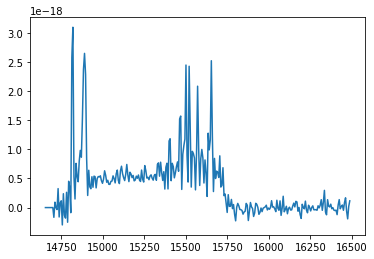

In [4]:
# Extract and visualize background
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/bkg.reg', mean=True)  # We use mean=True to take the mean of the emission in the region instead of the sum
plt.plot(bkg_axis, bkg_sky)

100%|██████████| 10/10 [00:00<00:00, 6257.35it/s]


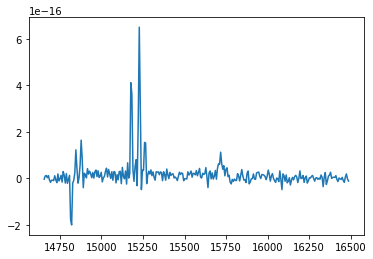

In [5]:
# Extract and visualize reigon
axis, sky = cube.extract_spectrum(1357, 1367, 608, 618, bkg=bkg_sky, mean=True)  # We use mean=True to take the mean of the emission in the region instead of the sum
plt.plot(axis, sky)

### Prepare for fit by loading in reference spectrum

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open(ML_ref+'.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

### Fit and visualize

In [11]:
fit = lfit.Fit(sky, axis, wavenumbers_syn, 'gaussian', ['Halpha'], [1], [1],
                keras.models.load_model(ML_model),
                 Plot_bool = False, bayes_bool=False)
fit_dict = fit.fit()

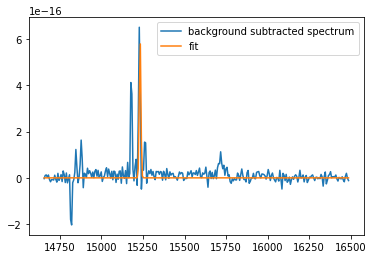

In [12]:
plt.plot(axis, sky-bkg_sky, label='background subtracted spectrum')
plt.plot(axis, fit_dict['fit_sol'], label='fit')
plt.legend()